Blank


In [30]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
# oversampler func
from oversampler_funtion import over_sampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow as tf

In [31]:
df = pd.read_csv('../../Data/complete_fire.csv')

In [32]:
df.dropna(inplace = True)

In [33]:
df.shape

(167273, 23)

In [34]:
df.dtypes

unique_fire_identifier     object
lattitude                 float64
longitude                 float64
acres_burned              float64
fire_cause                 object
incident_name              object
IsFSAssisted              float64
origin_county              object
state                      object
year                        int64
month                       int64
value                     float64
anomaly                   float64
area (acres)              float64
population                float64
d0                        float64
d1                        float64
d2                        float64
d3                        float64
d4                        float64
DSCI_avg                  float64
DSCI_summed               float64
precipitation(in)         float64
dtype: object

In [84]:
conditions = [df['acres_burned'] <= .25,
             (df['acres_burned'] > .25) & (df['acres_burned'] <= 9.9),
             (df['acres_burned'] > 9.9) & (df['acres_burned'] <= 99.99),
             (df['acres_burned'] > 99.99) & (df['acres_burned'] <= 299),
             (df['acres_burned'] > 299) & (df['acres_burned'] <= 999),
             (df['acres_burned'] > 999) & (df['acres_burned'] <= 5000),
             (df['acres_burned'] > 5000) & (df['acres_burned'] <= 9999),
             (df['acres_burned'] > 9999) & (df['acres_burned'] <= 49_999),
             (df['acres_burned'] > 49_999) & (df['acres_burned'] <= 100_000),
              (df['acres_burned'] > 100_000)
                
             ]
# choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
choices = [0,1,2,3,4,5,6,7,8,9]

df['class'] = np.select(conditions, choices, default = 0)

In [85]:
df.dtypes

unique_fire_identifier      object
lattitude                  float64
longitude                  float64
acres_burned               float64
incident_name               object
                            ...   
origin_county_Zavala         uint8
origin_county_Ziebach        uint8
fire_cause_Natural           uint8
fire_cause_Undetermined      uint8
fire_cause_Unknown           uint8
Length: 1403, dtype: object

In [37]:
df['class'].value_counts(normalize = True)

0    0.330621
1    0.230288
2    0.137398
5    0.112289
4    0.102718
3    0.080085
7    0.002983
6    0.002577
8    0.000544
9    0.000496
Name: class, dtype: float64

In [38]:

df = pd.get_dummies(df, columns = ['state', 'origin_county', 'fire_cause'], drop_first = True)

In [39]:
X = df.drop(columns = ['incident_name', 'unique_fire_identifier', 'class', 'acres_burned'])
y = df['class']

In [40]:
y = to_categorical(y)
# y = pd.get_dummies(y)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, stratify = y)

In [42]:
sc = StandardScaler()

In [43]:
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [44]:
X_train.shape

(125454, 1399)

In [45]:

model = Sequential()
model.add(Dense(32,
                input_shape = (1399,),
                activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [46]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [47]:

history = model.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1)

Epoch 1/10
3921/3921 [==============================] - 15s 4ms/step - loss: 1.3179 - acc: 0.5245 - val_loss: 1.1906 - val_acc: 0.5632
Epoch 2/10
3921/3921 [==============================] - 12s 3ms/step - loss: 1.1397 - acc: 0.5874 - val_loss: 1.1464 - val_acc: 0.5994
Epoch 3/10
3921/3921 [==============================] - 6s 2ms/step - loss: 1.0813 - acc: 0.6100 - val_loss: 1.1366 - val_acc: 0.6090
Epoch 4/10
3921/3921 [==============================] - 6s 2ms/step - loss: 1.0426 - acc: 0.6232 - val_loss: 1.1394 - val_acc: 0.6153
Epoch 5/10
3921/3921 [==============================] - 6s 1ms/step - loss: 1.0212 - acc: 0.6309 - val_loss: 1.1329 - val_acc: 0.6241
Epoch 6/10
3921/3921 [==============================] - 6s 2ms/step - loss: 1.0011 - acc: 0.6372 - val_loss: 1.1506 - val_acc: 0.6262
Epoch 7/10
3921/3921 [==============================] - 6s 1ms/step - loss: 0.9837 - acc: 0.6420 - val_loss: 1.1593 - val_acc: 0.6281
Epoch 8/10
3921/3921 [==============================] - 6s 1

In [48]:
preds = model.predict(Z_test)

In [49]:
rounded_preds = np.argmax(preds, axis = -1)
rounded_preds[101]

2

In [50]:
y_test2 = np.argmax(y_test, axis = -1)

In [51]:
y_test2[101]

2

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, rounded_preds))

              precision    recall  f1-score   support

           0       0.60      0.85      0.70     13826
           1       0.48      0.30      0.37      9630
           2       0.58      0.51      0.54      5746
           3       0.73      0.54      0.62      3349
           4       0.81      0.69      0.75      4295
           5       0.85      0.86      0.86      4696
           6       0.25      0.02      0.03       108
           7       0.12      0.01      0.02       125
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        21

    accuracy                           0.63     41819
   macro avg       0.44      0.38      0.39     41819
weighted avg       0.62      0.63      0.61     41819



C:\Users\dlc90\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dlc90\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dlc90\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


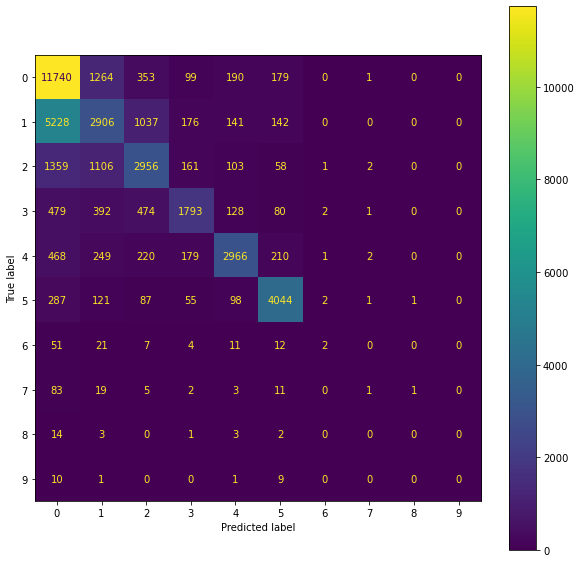

In [53]:

cm = confusion_matrix(y_test2, rounded_preds)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)


In [63]:
model2 = Sequential()
model2.add(Dense(64,
                input_shape = (1399,),
                activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(32, activation = 'relu'))

model2.add(Dense(10, activation = 'softmax'))

In [64]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [65]:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

history = model2.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1)

Epoch 1/10
3921/3921 [==============================] - 15s 4ms/step - loss: 1.1879 - acc: 0.5504 - val_loss: 1.0499 - val_acc: 0.6018
Epoch 2/10
3921/3921 [==============================] - 16s 4ms/step - loss: 1.0371 - acc: 0.6096 - val_loss: 1.0018 - val_acc: 0.6201
Epoch 3/10
3921/3921 [==============================] - 16s 4ms/step - loss: 0.9933 - acc: 0.6237 - val_loss: 0.9777 - val_acc: 0.6309
Epoch 4/10
3921/3921 [==============================] - 15s 4ms/step - loss: 0.9699 - acc: 0.6327 - val_loss: 0.9596 - val_acc: 0.6393
Epoch 5/10
3921/3921 [==============================] - 14s 4ms/step - loss: 0.9520 - acc: 0.6399 - val_loss: 0.9529 - val_acc: 0.6401
Epoch 6/10
3921/3921 [==============================] - 13s 3ms/step - loss: 0.9403 - acc: 0.6440 - val_loss: 0.9463 - val_acc: 0.6430
Epoch 7/10
3921/3921 [==============================] - 13s 3ms/step - loss: 0.9317 - acc: 0.6463 - val_loss: 0.9457 - val_acc: 0.6450
Epoch 8/10
3921/3921 [==============================] -

In [66]:
model3 = Sequential()
model3.add(Dense(128,
                input_shape = (1399,),
                activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))

model3.add(Dense(10, activation = 'softmax'))

model3.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [67]:
history = model3.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 30,
                    batch_size = 128,
                    verbose = 1)

Epoch 1/30
981/981 [==============================] - 9s 9ms/step - loss: 1.3235 - acc: 0.4930 - val_loss: 1.1172 - val_acc: 0.5827
Epoch 2/30
981/981 [==============================] - 10s 10ms/step - loss: 1.1056 - acc: 0.5811 - val_loss: 1.0432 - val_acc: 0.6036
Epoch 3/30
981/981 [==============================] - 9s 9ms/step - loss: 1.0410 - acc: 0.6045 - val_loss: 1.0029 - val_acc: 0.6179
Epoch 4/30
981/981 [==============================] - 9s 9ms/step - loss: 1.0052 - acc: 0.6180 - val_loss: 0.9886 - val_acc: 0.6250
Epoch 5/30
981/981 [==============================] - 9s 10ms/step - loss: 0.9857 - acc: 0.6259 - val_loss: 0.9741 - val_acc: 0.6348
Epoch 6/30
981/981 [==============================] - 8s 8ms/step - loss: 0.9690 - acc: 0.6318 - val_loss: 0.9633 - val_acc: 0.6377
Epoch 7/30
981/981 [==============================] - 8s 8ms/step - loss: 0.9576 - acc: 0.6365 - val_loss: 0.9559 - val_acc: 0.6380
Epoch 8/30
981/981 [==============================] - 8s 8ms/step - loss:

In [68]:
model4 = Sequential()
model4.add(Dense(128,
                input_shape = (1399,),
                activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(32, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))

model4.add(Dense(10, activation = 'softmax'))

model4.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [69]:
history = model4.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 100,
                    batch_size = 128,
                    verbose = 1)

Epoch 1/100
981/981 [==============================] - 9s 8ms/step - loss: 1.3225 - acc: 0.4960 - val_loss: 1.1186 - val_acc: 0.5781
Epoch 2/100
981/981 [==============================] - 7s 7ms/step - loss: 1.1039 - acc: 0.5807 - val_loss: 1.0436 - val_acc: 0.6066
Epoch 3/100
981/981 [==============================] - 8s 8ms/step - loss: 1.0442 - acc: 0.6059 - val_loss: 1.0084 - val_acc: 0.6169
Epoch 4/100
981/981 [==============================] - 7s 8ms/step - loss: 1.0110 - acc: 0.6180 - val_loss: 0.9842 - val_acc: 0.6259
Epoch 5/100
981/981 [==============================] - 7s 7ms/step - loss: 0.9860 - acc: 0.6253 - val_loss: 0.9728 - val_acc: 0.6315
Epoch 6/100
981/981 [==============================] - 7s 7ms/step - loss: 0.9699 - acc: 0.6312 - val_loss: 0.9622 - val_acc: 0.6351
Epoch 7/100
981/981 [==============================] - 7s 7ms/step - loss: 0.9573 - acc: 0.6365 - val_loss: 0.9594 - val_acc: 0.6374
Epoch 8/100
981/981 [==============================] - 6s 7ms/step - 

In [70]:
preds4 = model4.predict(Z_test)

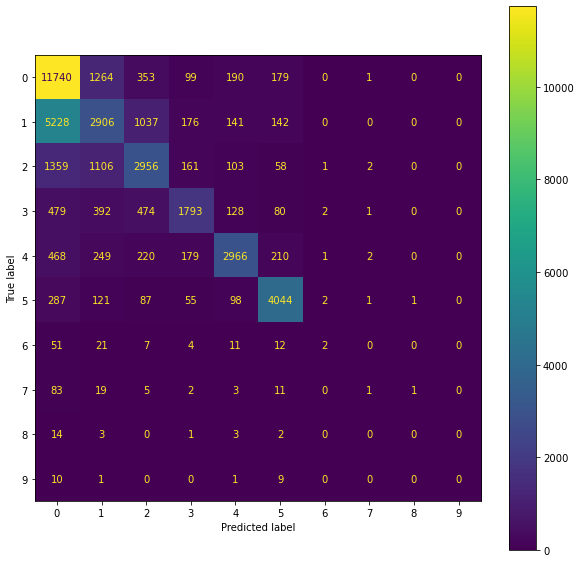

In [71]:
rounded_preds4 = np.argmax(preds4, axis = -1)

y_test4 = np.argmax(y_test, axis = -1)

cm4 = confusion_matrix(y_test4, rounded_preds4)

disp4 = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)


---
Attempting best neural net with more balanced classes

test
